<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/3_PyTorchNeuralNetwork/MNIST_RandomNumber_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST RandomNumber Addition using Pytorch
Write a neural network that can:
- take 2 inputs:
  - an image from MNIST dataset, and
  - a random number between 0 and 9
- and gives two outputs:
  - the "number" that was represented by the MNIST image, and
  - the "sum" of this number with the random number that was generated and sent as the input to the network 

## Import Libraries

Let's first import all the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

In [2]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [3]:
# We transform them to tensors
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# torchvision.datasets.MNIST outputs a set of PIL images
# Load and transform data
MNIST_train = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=train_transforms)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw




Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw




Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw




Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Creation of Random MNIST dataset



In [4]:
class RandomMNISTDataset(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    randomNo = random.randint(0,9)

    #Create one hot encoding for random number 
    one_hotrandomNo = torch.nn.functional.one_hot(torch.arange(0, 10))

    #add actual label and random number
    sum = label + randomNo
    return image, label, one_hotrandomNo[randomNo], sum

  def __len__(self):
    return len(self.MNISTDataset)

In [5]:
train_dataset = RandomMNISTDataset(MNIST_trainset)
val_dataset = RandomMNISTDataset(MNIST_valset)
test_dataset = RandomMNISTDataset(MNIST_testset)

In [6]:
print(f'The number of images in train dataset - {len(train_dataset)}')
print(f'The number of images in val dataset - {len(val_dataset)}')

print(f'The number of images in test dataset - {len(test_dataset)}')

The number of images in train dataset - 55000
The number of images in val dataset - 5000
The number of images in test dataset - 10000


In [7]:
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128)
test_loader = DataLoader(test_dataset,batch_size=128)

## View Sample batch




In [8]:
dataiter = iter(train_loader)
images, labels, randomNumbers, sums = dataiter.next()

print('Images: ', images.shape)
print('Labels: ', labels.shape)
print('Random Numbers: ', randomNumbers.shape)
print('Sum: ', sums.shape)

print('\nLabels: ', labels)
print('Random Numbers: ', randomNumbers)
print('Sum: ', sums)

Images:  torch.Size([128, 1, 28, 28])
Labels:  torch.Size([128])
Random Numbers:  torch.Size([128, 10])
Sum:  torch.Size([128])

Labels:  tensor([1, 9, 0, 9, 9, 9, 8, 2, 2, 0, 7, 9, 8, 3, 0, 7, 2, 3, 6, 2, 2, 9, 5, 0,
        2, 6, 3, 4, 6, 3, 7, 6, 0, 9, 2, 5, 4, 9, 9, 8, 4, 7, 6, 6, 8, 6, 5, 3,
        4, 1, 9, 7, 1, 3, 8, 7, 0, 9, 4, 4, 6, 6, 3, 5, 7, 1, 0, 1, 9, 8, 6, 9,
        8, 1, 8, 4, 2, 4, 2, 7, 3, 7, 5, 0, 0, 5, 2, 2, 6, 6, 8, 6, 4, 7, 4, 1,
        8, 7, 4, 6, 1, 2, 2, 2, 2, 9, 0, 7, 2, 0, 1, 2, 9, 5, 2, 6, 6, 7, 4, 1,
        1, 9, 3, 3, 6, 6, 3, 7])
Random Numbers:  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Sum:  tensor([ 6,  9,  4,  9, 13, 12, 11,  9,  4,  9,  8, 15, 10, 11,  6, 11,  4,  9,
         8,  7,  3, 10,  9,  6,  4, 14,  3,  8,  7, 12, 14, 15,  2, 10,  7,  6,
         4, 11, 16, 14, 11, 

## Defining the Model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1    Output:28 * 28 * 32    GRF:3 * 3  (GRF - Global Receptive Field)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 28*28*32   Output:28 * 28 * 64    GRF:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 28*28*64   Output:14 * 14 * 64    GRF:10*10 (for now we are considering that with max pooling, receptive field doubles - but this is not entirely correct)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 14*14*64   Output:14 * 14 * 128   GRF:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 14*14*128  Output:14 * 14 * 256   GRF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 14*14*256  Output: 7 * 7 * 256    GRF:28*28
        self.conv5 = nn.Conv2d(256, 512, 3)               #Input: 7*7*256    Output: 5 * 5 * 12     GRF:30*30
        self.conv6 = nn.Conv2d(512, 1024, 3)              #Input: 5*5*12     Output: 3 * 3 * 1024   GRF:32*32
        self.conv7 = nn.Conv2d(1024, 10, 3)               #Input: 3*3*1024   Output: 1 * 1 * 10     GRF:34*34


        self.fc1 = nn.Linear(10+10, 128)                  #Concatenate two inputs 
        # self.fc2 = nn.Linear(128, 30)
        self.fc2 = nn.Linear(128, 19)

    def forward(self, image, randomNumber):
        #The first convolutional layer self.conv1 has a convolutional operation on input tensor x, followed by a relu activation operation 
        #whcih is then passed to second convolution operation self.conv2 followed by a relu whose output is then passed to a max pooling 
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image)))))

        #The output of the max pool operation is passed to another two convolution and relu activation operation followed by max pooling. 
        #The relu() and the max_pool2d() calls are just pure operations. Neither of these have weights  
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        #The output of the max pool operation from 4th convolution is passed to another two sets of convolution and relu activation operation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The output from 6th convolution is then passed to a linear layer
        x = self.conv7(x)  
        
        #The flatten's all of the tensor's elements into a single dimension.
        x = x.view(-1, 10)
        
        #concatenate second input to the output from above convolution
        x1 = torch.cat((x, randomNumber), dim=1)
        
        # Further train the network on Dense Layer
        x1 = F.relu(self.fc1(x1))
        #x1 = F.relu(self.fc2(x1))    
        x1 = self.fc2(x1)  

        # Inside the network we usually use relu() as our non-linear activation function, but for the output layer, we use Softmax function for predicting category with maximum probability. 
        #The softmax function returns a positive probability for each of the prediction classes, and the values sum to 1.

        #Model returns two outputs:
          #Output1 : "number" represented by the MNIST image 
          #Output2 : "sum" of this number with the random number that was generated

        return F.log_softmax(x, dim = 1), F.log_softmax(x1, dim = 1)

## The Model

In [10]:
# move the model to the specified device
model = Net().to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
)

## Model parameters

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,384,925 trainable parameters


## Training Loop

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()

    epoch_loss = 0

    # run for all the data in train_loader
    for batch_idx, (data, target, random_number, sum) in enumerate(train_loader):

        # fetch the data and the target values
        target = target.type(torch.LongTensor)
        sum = sum.type(torch.LongTensor)

        # move the data to device
        data, target, sum = data.to(device), target.to(device), sum.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output, sum_output = model(data,random_number.to(device))

        # compute the loss occured
        mnist_loss = F.nll_loss(output, target)
        addition_loss = F.nll_loss(sum_output, sum)
        loss= (mnist_loss + addition_loss)/2

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()
    print('Train set: Average loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss



## Testing Loop

In [13]:
def test(model, device, test_loader,test_type='Val'):
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct_mnist = 0
    correct_addition = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for (data, target, random_number, sum) in test_loader:

            # move the data to device
            target = target.type(torch.LongTensor)
            sum = sum.type(torch.LongTensor)
            data, target,sum = data.to(device), target.to(device), sum.to(device)

            # forward pass the model and get the output
            output, sum_output = model(data,random_number.to(device))

            # accumulate the loss from both the network outputs
            test_loss += (F.nll_loss(output, target, reduction='sum').item() + F.nll_loss(sum_output, sum, reduction='sum').item())/2

            # get the index of max log-probability
            mnist_pred = output.argmax(dim=1, keepdim=True)
            addition_pred = sum_output.argmax(dim=1, keepdim=True)

            # increment the correct prediction count if pred is correct
            correct_mnist += mnist_pred.eq(target.view_as(mnist_pred)).sum().item()
            correct_addition += addition_pred.eq(sum.view_as(addition_pred)).sum().item()


    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)
    print(f'{test_type} set: Average loss: {test_loss:.3f}, MNist Accuracy:{100. * correct_mnist/len(test_loader.dataset)}, Sum_Accuracy:{100. * correct_addition/len(test_loader.dataset)}')

    return test_loss


## Let's write train and test the model

In [14]:
# move the model to the specified device
model = Net().to(device)

# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 25

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    valid_loss = test(model, device, val_loader)
    # test the model

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)


Epoch 1 : 
Train set: Average loss: 1.3915
val set: Average loss: 1.368, MNist Accuracy:93.04, Sum_Accuracy:10.88

Epoch 2 : 
Train set: Average loss: 1.2572
val set: Average loss: 1.248, MNist Accuracy:96.16, Sum_Accuracy:15.22

Epoch 3 : 
Train set: Average loss: 1.1600
val set: Average loss: 1.188, MNist Accuracy:96.9, Sum_Accuracy:17.76

Epoch 4 : 
Train set: Average loss: 1.1511
val set: Average loss: 1.125, MNist Accuracy:97.82, Sum_Accuracy:29.12

Epoch 5 : 
Train set: Average loss: 1.0766
val set: Average loss: 1.075, MNist Accuracy:98.24, Sum_Accuracy:38.64

Epoch 6 : 
Train set: Average loss: 0.9500
val set: Average loss: 1.012, MNist Accuracy:98.04, Sum_Accuracy:41.8

Epoch 7 : 
Train set: Average loss: 0.9224
val set: Average loss: 0.926, MNist Accuracy:98.38, Sum_Accuracy:57.8

Epoch 8 : 
Train set: Average loss: 0.7930
val set: Average loss: 0.852, MNist Accuracy:98.4, Sum_Accuracy:66.42

Epoch 9 : 
Train set: Average loss: 0.7626
val set: Average loss: 0.767, MNist Accu

## Ploting the loss 

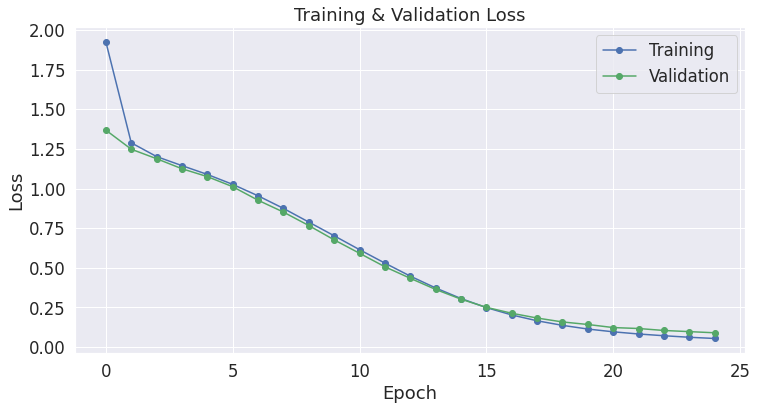

In [15]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Test Loss

In [16]:
test_loss = test(model, device, test_loader,'Test')

Test set: Average loss: 0.072, MNist Accuracy:99.27, Sum_Accuracy:99.24


## Inference

In [17]:
def prediction(image,rnum):

    rnum_ohe = torch.zeros(11).long()
    rnum_ohe[rnum] = 1
    rnum_ohe = rnum_ohe[:-1]

    #tensored_image = image.unsqueeze(dim=1).to(device)
    output_1,output_2 = model(image.unsqueeze(dim=1).to(device),rnum_ohe.reshape(-1,10).to(device))

    mnist_pred = output_1.argmax(dim=1, keepdim=True)
    sum_pred = output_2.argmax(dim=1, keepdim=True)

    #print(f"Random Number Generated is {rnum}")
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(3, 3, 1)
    ax.axis('off')
    ax.imshow(image.cpu().numpy().squeeze())
    ax.set_title(f'Random Number Generated : {rnum} \n'
                 f'Mnist Prediction: {mnist_pred.item()} \n'
                 f'Sum: {rnum} + {mnist_pred.item()} = {sum_pred.item()}')
    return mnist_pred, sum_pred

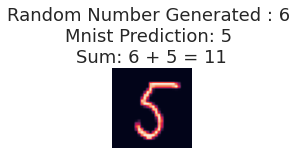

In [18]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)

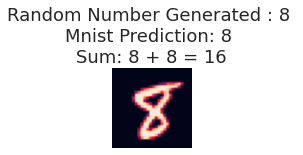

In [19]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)

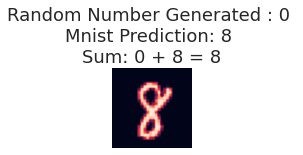

In [20]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)

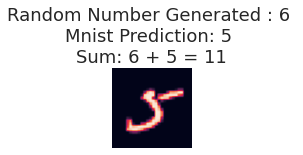

In [21]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)